<div align="center">

# MEGR7172/8172

### Computational Methods (Fall 2025)
### Duke 227, Tu/Th 08:30 - 09:45 pm

</div>


# 12 2D problems

Let's continue our journey in optimization. If we extend the gradient descent algorithm to two-variables system. How shall we implements it.

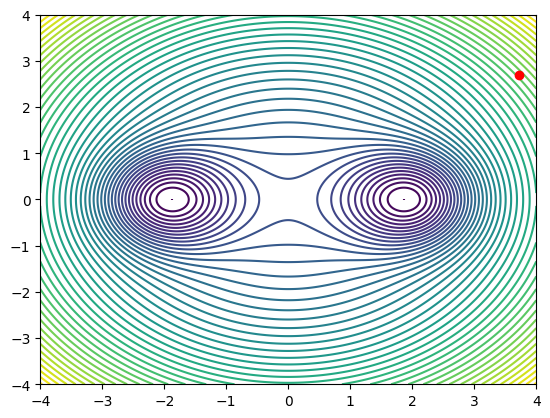

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x): #simple function with 1 minimum
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 # + 3* np.exp(-x[0]**2)

def f2(x): # 2D function with two valleys
    # Two Gaussian valleys centered at (-2, 0) and (2, 0)
    return (
        0.2 * (x[0]**2 + x[1]**2)
        - 3.0 * np.exp(-((x[0] + 2)**2 + x[1]**2))
        - 3.0 * np.exp(-((x[0] - 2)**2 + x[1]**2))
    )

def init(x_min, x_max, y_min, y_max):
    x0 = x_min+np.random.random()*(x_max-x_min)
    y0 = y_min+np.random.random()*(y_max-y_min)
    return [x0, y0]

x_min, x_max = -4, 4
y_min, y_max = -4, 4                   

nx = np.linspace(x_min,x_max,400)
ny = np.linspace(y_min,y_max,400)

x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.2)
plt.contour(x,y,z, levels=levels)

x0, y0 = init(x_min, x_max, y_min, y_max)
plt.plot(x0, y0, 'ro')
plt.show()


## 12.1 Gradient descent with variable step size

We will start with the gradient descent method and variable step size as we implemented in the previous lecture.

In [2]:
def derivative2(f, x, h=1e-6):
    """
    f: function
    x: 1*2 array
    h: step size
    """
    x = np.asarray(x, dtype=float)
    h_vec = np.eye(x.size) * h
    f_x1 = np.array([f(x + h_vec[i]) for i in range(x.size)])
    f_x2 = np.array([f(x - h_vec[i]) for i in range(x.size)])
    df = (f_x1 - f_x2) / (2 * h)
    return df

def minimize(f, x0, N=1000):
    """
    x0: 1*2 array
    """
    
    x_now = x0
    x_prev = None
    converged = False
    x_hist = []
    x_hist.append(x_now)
    for i in range(N):
        
        df_now = derivative2(f2, x_now) 
        
        if x_prev is None:
            dx = 0.01
        else:
            df_prev = derivative2(f2, x_prev)
            dd = df_now - df_prev
            dx = np.dot(x_now - x_prev, dd) / (np.linalg.norm(dd))**2
        x_next = x_now - df_now*dx

        if f(x_next) > f(x_now):
            converged = True
            break
        else:
            x_prev = x_now
            x_now = x_next
            x_hist.append(x_now)

    return converged, np.array(x_hist), f(x_now)

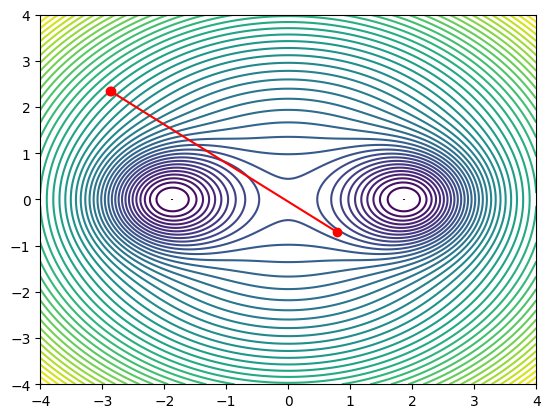

f_min:  -0.197477 with   3 iterations
[-2.87698023  2.35375915] 2.7579814269665546
[ 0.78224552 -0.70010193] -0.19747732184517558


In [3]:
[x0, y0] = init(x_min, x_max, y_min, y_max)
converged, x_hist, f_min = minimize(f2, [x0,y0])
x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.2)
plt.contour(x,y,z, levels=levels)

plt.plot(x_hist[:,0], x_hist[:,1], 'ro-')
plt.show()
print(f'f_min: {f_min:10.6f} with {len(x_hist):3d} iterations')
print(x_hist[0], f2(x_hist[0]))
print(x_hist[-1], f2(x_hist[-1]))

## 12.2 Line Search

In practical optimization, line search is a fundamental technique used to find an appropriate step size when moving along a given search direction. The main idea is to minimize the objective function along a line defined by the current point and the search direction. By choosing an optimal step size, line search methods help ensure efficient convergence and stability in iterative optimization algorithms such as gradient descent and conjugate gradient methods. Common strategies include exact line search, which finds the minimum along the line, and inexact line search, which seeks a step size that sufficiently reduces the objective function according to certain criteria (e.g., Armijo or Wolfe conditions).

Let's visualize how different step sizes affect the progress of gradient descent. The plot below shows the path taken by gradient descent with a fixed large step size (which may overshoot), a small step size (which converges slowly), and an optimal step size found by line search.


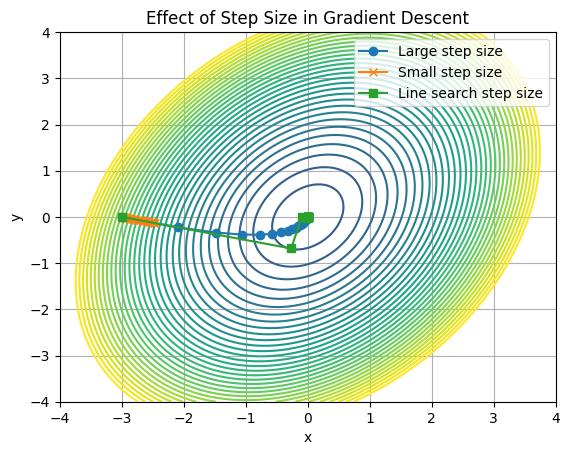

In [4]:
from scipy.optimize import minimize_scalar
# Define a starting point
x0, y0 = -3, 0
start = np.array([x0, y0])

# Fixed large step size
def gd_fixed_step(f, grad_f, x0, alpha, max_iter=20):
    x = np.array(x0, dtype=float)
    x_hist = [x.copy()]
    for _ in range(max_iter):
        r = -grad_f(f, x)
        x = x + alpha * r
        x_hist.append(x.copy())
    return np.array(x_hist)

# Line search step size
def gd_line_search(f, grad_f, x0, max_iter=20):
    x = np.array(x0, dtype=float)
    x_hist = [x.copy()]
    for _ in range(max_iter):
        r = -grad_f(f, x)
        def phi(alpha):
            return f(x + alpha * r)
        res = minimize_scalar(phi)
        alpha = res.x if res.success else 0.01
        x = x + alpha * r
        x_hist.append(x.copy())
    return np.array(x_hist)

# Compute paths
x_hist_large = gd_fixed_step(f1, derivative2, start, alpha=0.3)
x_hist_small = gd_fixed_step(f1, derivative2, start, alpha=0.01)
x_hist_ls = gd_line_search(f1, derivative2, start)

# Plot
z = f1([x, y])
plt.contour(x, y, z, levels=levels)
plt.plot(x_hist_large[:,0], x_hist_large[:,1], 'o-', label='Large step size')
plt.plot(x_hist_small[:,0], x_hist_small[:,1], 'x-', label='Small step size')
plt.plot(x_hist_ls[:,0], x_hist_ls[:,1], 's-', label='Line search step size')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Effect of Step Size in Gradient Descent')
plt.grid()
plt.show()

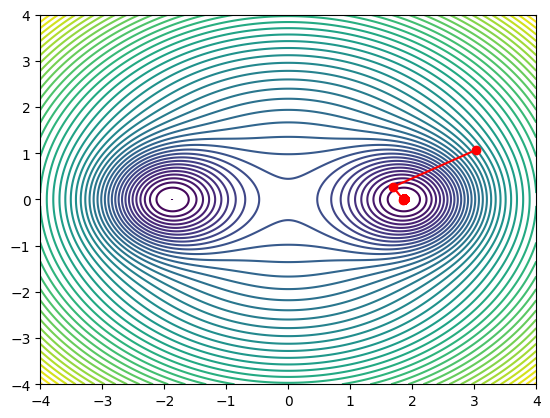

f_min:  -2.250376 with 1001 iterations
[3.03511574 1.0765572 ] 1.7517372092754377
[1.87309833e+00 4.33162339e-10] -2.2503762746039575


In [5]:
from scipy.optimize import minimize_scalar

def minimize_gd_linesearch(f,x0, N=1000):
    """
    x0: 1*2 array
    """
    
    x_now = x0
    x_prev = None
    converged = False
    x_hist = []
    x_hist.append(x_now)
    for i in range(N):
        df_now = derivative2(f, x_now)
        direction = -df_now

        # Line search to find optimal step size along the direction
        def phi(alpha):
            return f(x_now + alpha * direction)
        res = minimize_scalar(phi)
        dx = res.x if res.success else 0.01

        x_next = x_now + dx * direction

        if f(x_next) > f(x_now):
            converged = True
            break
        else:
            x_prev = x_now
            x_now = x_next
            x_hist.append(x_now)

    return converged, np.array(x_hist), f(x_now)

[x0, y0] = init(x_min, x_max, y_min, y_max)
converged, x_hist, f_min = minimize_gd_linesearch(f2, [x0,y0])
x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.2)
plt.contour(x,y,z, levels=levels)

plt.plot(x_hist[:,0], x_hist[:,1], 'ro-')
plt.show()
print(f'f_min: {f_min:10.6f} with {len(x_hist):3d} iterations')
print(x_hist[0], f2(x_hist[0]))
print(x_hist[-1], f2(x_hist[-1]))



## 12.3 Conjungate Gradient
As you have seen in the gradient descent method the algorithm makes steps in same direction several times. 
$$ d_0 = \gamma \nabla f(x_0)$$

Here’s an idea: let’s pick a set of orthoginal search directions so that if we take exactly one step of right length in each of those directions we will reach the minimum. In order to rectify this, we require that our directions be conjugate to one another.

$$ d_1 = \nabla f(x_1) + \beta_0d_0$$

See more details in [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_gradient_method)


CG minimum: 0.000000 at [6.54759996e-11 3.63755692e-11]
GD minimum: 0.000000 at [-2.28012909e-08  1.63116927e-07]


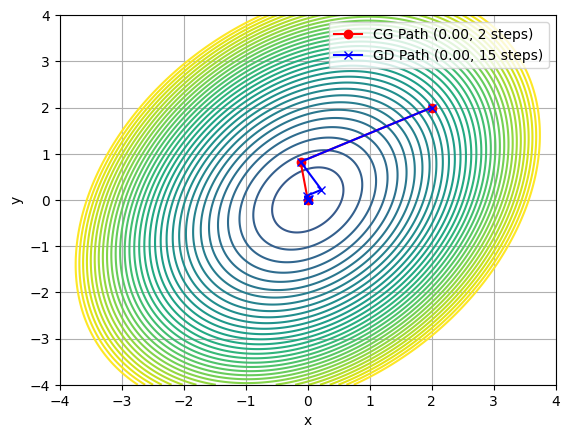

In [6]:
from scipy.optimize import minimize_scalar

def conjugate_gradient(f, grad_f, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    r = -grad_f(f, x)
    d = r.copy()
    x_hist = [x.copy()]
    for i in range(max_iter):
        # Line search for optimal step size along direction d
        def phi(alpha):
            return f(x + alpha * d)
        res = minimize_scalar(phi)
        alpha = res.x if res.success else 0.01

        x_new = x + alpha * d
        r_new = -grad_f(f, x_new)
        x_hist.append(x_new.copy())
        if np.linalg.norm(r_new) < tol:
            break
        # For non-quadratic functions, CG can take a spiral path due to non-conjugacy of directions
        beta = np.dot(r_new, r_new) / (np.dot(r, r) + 1e-12)
        d = r_new + beta * d
        x = x_new
        r = r_new
    return np.array(x_hist), f(x_new)

def gradient_descent(f, grad_f, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    x_hist = [x.copy()]
    for i in range(max_iter):
        r = -grad_f(f, x)
        # Line search for optimal step size
        def phi(alpha):
            return f(x + alpha * r)
        res = minimize_scalar(phi)
        alpha = res.x if res.success else 0.01
        x_new = x + alpha * r
        x_hist.append(x_new.copy())
        if np.linalg.norm(r) < tol:
            break
        x = x_new
    return np.array(x_hist), f(x_new)

x0, y0 = 2, 2
z = f1([x, y])

# Run CG minimization
x_hist_cg, f_min_cg = conjugate_gradient(f1, derivative2, [x0, y0])
print(f'CG minimum: {f_min_cg:.6f} at {x_hist_cg[-1]}')

# Run GD minimization
x_hist_gd, f_min_gd = gradient_descent(f1, derivative2, [x0, y0])
print(f'GD minimum: {f_min_gd:.6f} at {x_hist_gd[-1]}')

# Plot CG path on contour
plt.contour(x, y, z, levels=levels)
plt.plot(
    x_hist_cg[:, 0], x_hist_cg[:, 1], marker='o', color='red',
    label=f'CG Path ({f_min_cg:.2f}, {len(x_hist_cg)-1} steps)'
)
plt.plot(
    x_hist_gd[:, 0], x_hist_gd[:, 1], marker='x', color='blue',
    label=f'GD Path ({f_min_gd:.2f}, {len(x_hist_gd)-1} steps)'
)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


## 12.4 Minimization Packages in Scipy

Optimization terminated successfully.
         Current function value: -2.250376
         Iterations: 49
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -2.250376
         Iterations: 9
         Function evaluations: 60
         Gradient evaluations: 20


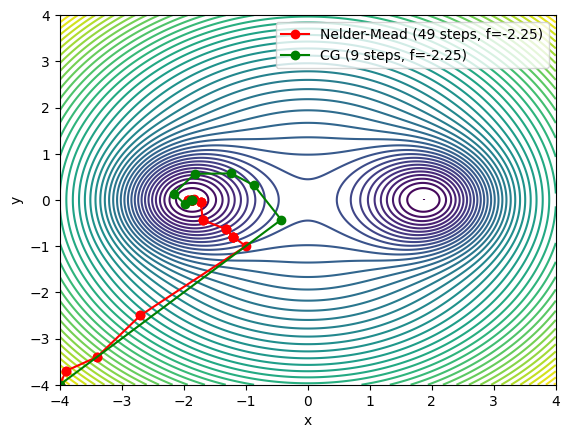

In [7]:
from scipy.optimize import minimize

#[x0, y0] = init(x_min, x_max, y_min, y_max)

x0, y0 = -4, -4

methods = ['nelder-mead', 'CG']#, 'BFGS']#, 'powell']
labels = ['Nelder-Mead', 'CG']#, 'BFGS']#, 'Powell']
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots()
z = f2([x, y])
ax.contour(x, y, z, levels=levels)

for method, label, color in zip(methods, labels, colors):
    # Store the trajectory of points
    trajectory = []

    def callback(xk):
        trajectory.append(np.copy(xk))

    # For methods that support trajectory, pass callback and store allvecs
    options = {'disp': True}
    if method.lower() in ['cg', 'bfgs', 'nelder-mead', 'powell']:
        res = minimize(f2, [x0, y0], method=method, tol=1e-4, options={**options, 'return_all': True}, callback=callback)
        # For Nelder-Mead, trajectory is in res.allvecs; for CG, use callback
        if hasattr(res, 'allvecs') and len(res.allvecs) > 0:
            traj = np.array(res.allvecs)
        elif len(trajectory) > 0:
            traj = np.vstack(([x0, y0], trajectory))
        else:
            traj = np.vstack(([x0, y0], res.x))
    else:
        res = minimize(f2, [x0, y0], method=method, tol=1e-4, options=options)
        traj = np.vstack(([x0, y0], res.x))

    ax.plot(traj[:,0], traj[:,1], marker='o', color=color, 
            label=f"{label} ({len(traj)-1} steps, f={f2(traj[-1]):.2f})")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()